# Introduction

This project is about finding E-sport highlight moments by analyzing [Twitch](https://www.twitch.tv/) chats. 

First, we need to know what are highlight moments. We define the highlight moments as follows:

> Players' incredible operations, unbelievable team cooperation, dramatic come back, embarrassing moments and so on. We call moments audiences like highlight moments.

Also, we need to get familiar with our platform, which is Twitch:

> Twitch is a live streaming video platform owned by Twitch Interactive, a subsidiary of Amazon. Introduced in June 2011 as a spin-off of the general-interest streaming platform, Justin.tv, the site primarily focuses on video game live streaming, including broadcasts of eSports competitions, in addition to creative content, "in real life" streams, and more recently, music broadcasts. Content on the site can either be viewed live or via video on demand.
>
> ––– Wikipedia

The Twitch has a feature called "Twitch Chat":

> On Twitch Streaming, audiences can talk to other audiences and broadcasters by sending chats. Comparing with TV streming, audiences of Tw
itch streaming can interact with others by chatting. So we believe that to some degrees, chats can relect audiences' reaction of current streaming.

That being said, our project seems can be perform on another topic as well. So why do we choose E-sport?

> This is because, first, the e-sport streams usually have many viewers. For example, a match in OWL usually has 100k viewers. Also, these viewers are quite likely to spam in the chat to cheer for their teams. This makes it easy for us to get enough data points. In fact, the chat messages in a single match are usually enough for us to train our model!
>
> Also, because we like it :)

The video below may be able to help you understand the idea of highlight moments and chats.

In [63]:
from IPython.display import HTML
embed_video = '<iframe width="560" height="315" src="https://www.youtube.com/embed/f6rN_vhAHIY" frameborder="0" allow="autoplay; encrypted-media" allowfullscreen></iframe>'
HTML(data=embed_video)

As you can see in the video, when some highlights happen, the Twitch chat will react to it almost instantly. This means we don't need to analyse the contents of the video to predict the highlights, which would require a lot more works. Instead, we can just predict the highlights from the chat, which is basiclly the reaction of the users.

For example, in the video, you can see that when the player did a fantastic play, many people in the chat began to spam "PogChamp", which is a Twitch emote that expresses awesomeness. On the other side, when some of the players did something very poorly or very funny, the Twitch chat would be filled with "LUL", which is another Twitch emote that expresses laughing.

So the basic idea is, depending on the contents of the video, the word frequency, reaction frequency and other features in the Twitch chat will change accordingly. As a result, by analysing the features of the chat on Twitch, we can predict the highlights of the match.

# Data Preparation

So for our task, what data do we need?

* E-sport videos

* Chats of these videos

* Marked highlight moments

For E-sport videos, we don't really need to download raw file, since we can watch these videos on Twitch. We just need to some meta informations of these videos, for example, durations, video owners, game categories and so on.

For chats of these videos, we need to know where and when these chats appear, who sent these chats, and their contents. 

For marked highlight moments, they may be not necessary, since the criteria of highlight moments are very subjective. Unsupervised learning may work for this task. But in most cases, supervisored learning is better. We found that Twitch has a good feature, clips. This feature allows Twitch viewers to share from previous broadcasts. We have reasons to believe that viewers won’t share meaningless moments in general. So we can regard clips as manual labeled highlight moments. 

# Details about data collection

Data collection involves amount of codes, so we put these codes into separated Python files instead of include them in this notebook.

## E-sport videos
Most E-sport championships have a channel. So we can get many E-sports videos by crawling videos of E-sport championships channels. Twitch provides APIs to get meta informations of videos, so it's not hard to collect this part of data by APIs.

## Chats of these videos
This part is a bit complex because Twitch doesn't publish APIs of retrieving chats. But we think there should be such an API because a video has amount of chats, so chats cannot be loaded one time. Therefore we monitored network traffics when we watched streaming to find this API. Finally we found this API and a surprise is that we found a magic client ID (you need register Twitch developers to get a client ID to use Twitch APIs), no matter how I clean up cookies or changed IP addresses, it keeps same. So we beleive that this magic client ID is for all browser users and there should be no limitation for this client ID. 

## Marked highlight moments
Similar to videos, Twitch provides APIs for clips, so this part is almost as same as E-sport videos.

## Retry
We don't use frameworks to crawl data and all our data were collected by HTTP APIs, which may get failed, so we implemented failed retry in our crawling functions.

## Multiprocessing and data cache
Since there is a lot of data (especially chats data), retrieving data in a single process may take too much time. Therefore we use multiprocessing to accelerate this process. Also, due to crawling takes much time, we store crawled data into local disks to avoid crawl the data again.

# Data analysis
To extract highlight moments, we need find some properties of highlight moments. So let's do some analysis. We will use [Video 258310143](https://www.twitch.tv/videos/258310143) as our sample to analyze. 

In [64]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np

import twitch_data

# The video ID we anaylze  
video_id = "258095092"

Since we cached data, we need to initialize directory structure for data caching.

In [65]:
twitch_data.init_directory_structure()

Get all clips on this channel and all chats of this video.

In [66]:
video_infos = twitch_data.load_video_infos('overwatchleague')
clips = twitch_data.load_clips('overwatchleague')
chats = twitch_data.load_chats(video_id)

Find all clips of this video from all clips on this channel.

In [67]:
video2clips = {clip.video_id:[] for clip in clips}
for clip in clips:
    video2clips[clip.video_id].append(clip)
video_related_clips = video2clips[video_id]

Get video meta informations.

In [68]:
video_info = twitch_data.twitch_get_video_info(video_id)
video_length = twitch_data.duration_str_to_seconds(video_info['duration'])

Durations of clips, we can see highlgiht moments are very short.

In [69]:
durations = list(map(lambda x:x.duration, video_related_clips))
print("Clip max duration(sec):", max(durations))
print("Clip min duration(sec):", min(durations))
print("Clips average duration(sec):", sum(durations) / len(durations))
print("Video duration(s):", video_length)

Clip max duration(sec): 60.01
Clip min duration(sec): 5.01
Clips average duration(sec): 21.606946564885504
Video duration(s): 23831


In the following part of this project, we will split videos into equal length windows. The windows are basic units we explore. We will do model training and highlight extraction with windows. Here we set basic window size to 20 because average duration of highlgiht moments is close to 20.

In [70]:
import twitch_feature
sample_window_size = 20

A reasonable idea about highlight moments is that viewers are more likely to chat during highlight moments. Let's see if it is true.

Chats density of a window means the number of chats in the window.

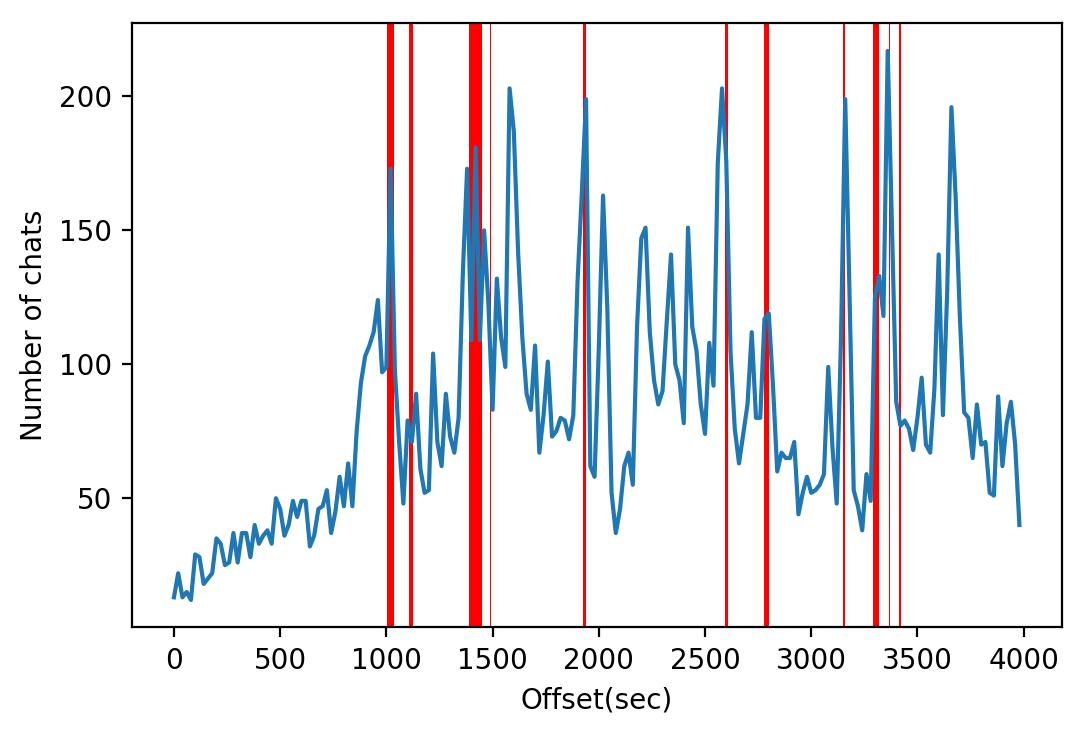

In [71]:
def plot_chats_density(chats, clips, video_length, sample_window_size, chats_density):
    fig = plt.figure(dpi=200)
    plt.xlabel("Offset(sec)")
    plt.ylabel("Number of chats")

    plot_x = range(0, video_length, sample_window_size)
    cut_edge = min(200, len(plot_x))
    
    for clip in clips:
        if clip.video_offset + clip.duration < cut_edge * sample_window_size:
            plt.axvspan(clip.video_offset, clip.video_offset + clip.duration, facecolor='r')
    plt.plot(plot_x[:cut_edge], chats_density[:cut_edge])
    return fig

chats_density = twitch_feature.calculate_chats_density(chats, video_length, sample_window_size)
plot_chats_density(chats, video_related_clips, video_length, sample_window_size, chats_density)
plt.show()

Thre red areas are highlight moments. We can see that in most cases highlight moments occur with chats density peaks. And another thing may be important is that comparing with the whole video, the total duration of highlight moments is short.

Another idea about highlight moments is that highlight moments may make some viewers usually don't send chats send chats. We define another feature to describe this assumption. We call it active user density, it means how many users speak in a window.

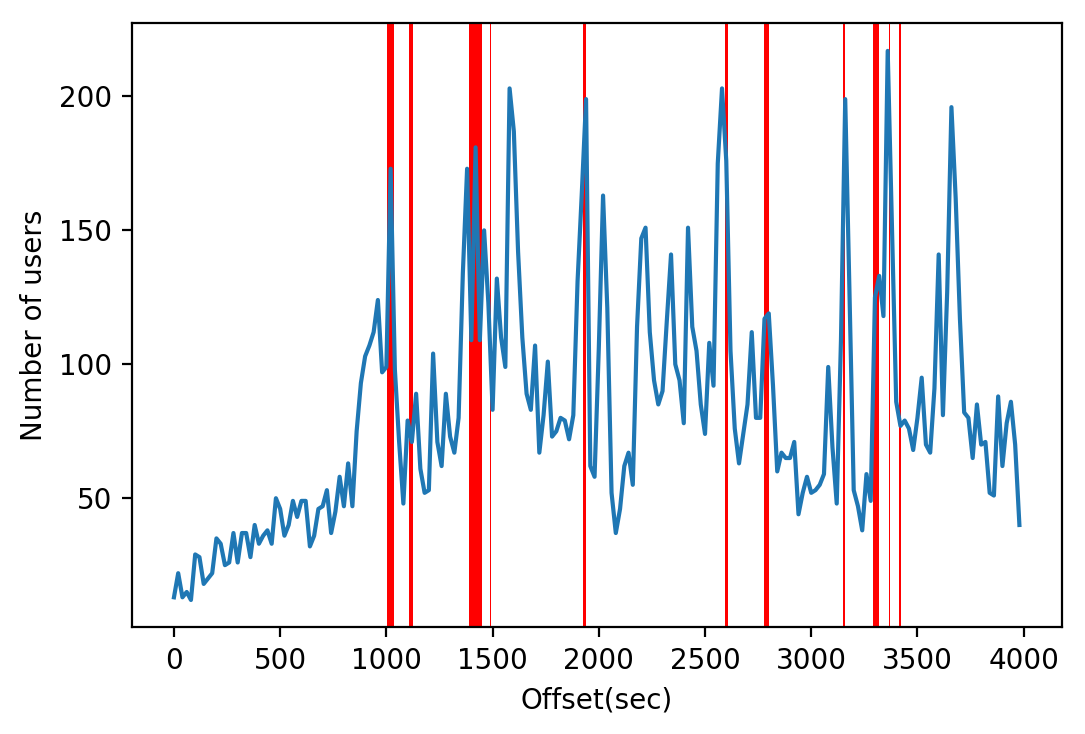

In [72]:
def plot_active_user_density(chats, clips, video_length, sample_window_size, activer_user_density):
    fig = plt.figure(dpi=200)
    plt.xlabel("Offset(sec)")
    plt.ylabel("Number of users")

    plot_x = range(0, video_length, sample_window_size)    
    cut_edge = min(200, len(plot_x))
    
    for clip in clips:
        if clip.video_offset + clip.duration < cut_edge * sample_window_size:
            plt.axvspan(clip.video_offset, clip.video_offset + clip.duration, facecolor='r')
    plt.plot(plot_x[:cut_edge], chats_density[:cut_edge])
    return fig

activer_user_density = twitch_feature.calculate_active_user_density(chats, video_length, sample_window_size)
plot_active_user_density(chats, video_related_clips, video_length, sample_window_size, activer_user_density)
plt.show()

We can see that in most cases highlight moments occur with active user density peaks.

Beyond data visualization, let's also see if there is statistical difference between highlight moments and other parts of the video.

In [73]:
labels = twitch_feature.calculate_label(video_related_clips, video_length, sample_window_size)

In [74]:
print("Clip average # of chats:", np.mean(chats_density[labels == 1]))
print("Other parts average # of chats:", np.mean(chats_density[labels == 0]))
print("Clip variance of # of chats:", np.var(chats_density[labels == 1]))
print("Other parts variance of # of chats:", np.var(chats_density[labels == 0]))
print("Clip average # of active users:", np.mean(chats_density[labels == 1]))
print("Other parts average # of active users:", np.mean(activer_user_density[labels == 0]))
print("Clip variance of # of active users:", np.var(activer_user_density[labels == 1]))
print("Other parts variance of # of active users:", np.var(activer_user_density[labels == 0]))

Clip average # of chats: 115.25128205128205
Other parts average # of chats: 80.92276830491474
Clip variance of # of chats: 3181.900959894806
Other parts variance of # of chats: 1645.4534133996774
Clip average # of active users: 115.25128205128205
Other parts average # of active users: 72.14744232698094
Clip variance of # of active users: 2544.9329125575277
Other parts variance of # of active users: 1292.3463650731533


We can see that the average of chats density and active user density of highlight is significantly greater than other parts. So we have reasons to believe these two feature may be helpful for us to find highlight moments.
 
Another idea is that words viewers use in highlight moments may be different from usual. For example, when a player does some incrediable operations, viewers may send the player's name. So word frequency analysis may be good for our purpose. Here we use TF-IDF to describe it because there are always some dummy words like lol, lul in chats, so bags of words model doesn't work well in this case.

In [75]:
texts = twitch_feature.extract_text(chats, video_length, sample_window_size)
vectorizer, tfidf_features = twitch_feature.train_and_transform_tfidf(texts)

In [76]:
from sklearn.metrics.pairwise import cosine_similarity

print("Cos similarity between clips \t\t\t%f" % np.mean(cosine_similarity(tfidf_features[labels == 1], tfidf_features[labels == 1])))
print("Cos similarity between clips and unclips \t%f" % np.mean(cosine_similarity(tfidf_features[labels == 1], tfidf_features[labels == 0])))
print("Cos similarity between unclips \t\t\t%f" %np.mean(cosine_similarity(tfidf_features[labels == 0], tfidf_features[labels == 0])))

Cos similarity between clips 			0.123665
Cos similarity between clips and unclips 	0.103654
Cos similarity between unclips 			0.102148


We can find that average cos similarity between highlight moments is greater. So words viewers use in highlight moments may have some properties.

Furthermore, let's see the overlap between high-frequency words in highlight moments and other parts.

In [77]:
from wordcloud import WordCloud
from collections import Counter

clip_concat_feature = np.asarray(np.sum(tfidf_features[labels == 1], axis=0)).squeeze()
unclip_concnat_feature = np.asarray(np.sum(tfidf_features[labels == 0], axis=0)).squeeze()
index2word = {v:k for k,v in vectorizer.vocabulary_.items()}
clip_chats_counter = {}
unclip_chats_counter = {}
for i in index2word:
    clip_chats_counter[index2word[i]] = clip_concat_feature[i]
    unclip_chats_counter[index2word[i]] = unclip_concnat_feature[i]

In [78]:
a = sorted(list(clip_chats_counter.items()), key=lambda x: -x[1])
b = sorted(list(unclip_chats_counter.items()), key=lambda x: -x[1])
for top in [10, 50, 100]:
    overlap = 0
    top_word_a = [tu[0] for tu in a[:top]]
    top_word_b = [tu[0] for tu in b[:top]]
    for word in top_word_a:
        if word in top_word_b:
            overlap += 1
    print("Top %d\toverlap:\t" % top, overlap,'/',top,"\t", overlap/top)

Top 10	overlap:	 7 / 10 	 0.7
Top 50	overlap:	 38 / 50 	 0.76
Top 100	overlap:	 79 / 100 	 0.79


What's more, let's see wordcloud of highlight moments and other parts.

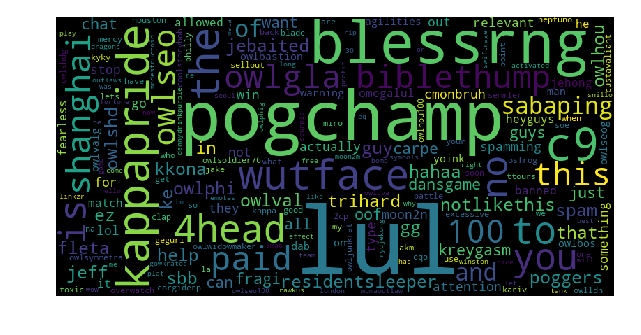

In [79]:
clip_wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(clip_chats_counter)

plt.figure(dpi=120)
plt.imshow(clip_wordcloud)
plt.axis("off")
plt.show()

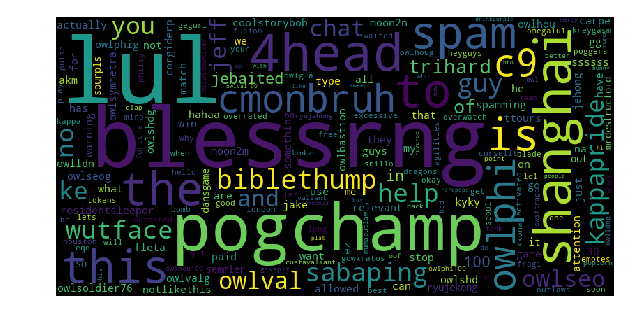

In [80]:
unclip_wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(unclip_chats_counter)

plt.figure(dpi=120)
plt.imshow(unclip_wordcloud)
plt.axis("off")
plt.show()

In [81]:
def twitch_play_video(video_id, offset):
    html_str = '<iframe src="https://player.twitch.tv/?autoplay=false&t=%ds&video=%s" frameborder="0" allowfullscreen="true" scrolling="no" height="378" width="620"></iframe>' % (offset, video_id)
    return HTML(data=html_str)

twitch_play_video(video_id, video_related_clips[0].video_offset)

# Training

Now that we have all the feature extracted, we can finally train our model!

## Merge Features

Before we move on to train our model using the data we just collected, we have to merge all the features at first. From the previous section, we have already calculated the following features:

- `chats_density`
- `activer_user_density`
- `tfidf_features`

The dimensions of these features are as follow:

In [82]:
print(chats_density.shape)
print(activer_user_density.shape)
print(tfidf_features.shape)

(1192,)
(1192,)
(1192, 17598)


In order to merge all these extracted features into a large feature matrix, we can call `sp.hstack()` to add two columns to the sparse matrix we have (which is `tfidf_features`).

Notice that, here we called `tocsr()` to transform the feature matrix into a CSR formatted sparse matrix. This is for the convinience of spliting the dataset, as each row represents a time window (i.e. a sample) in the dataset.

In [83]:
import scipy.sparse as sp

features = sp.hstack((chats_density[:, None], activer_user_density[:, None], tfidf_features)).tocsr()
features.shape

(1192, 17600)

## Split Dataset

After merging all the features we have into a large sparse feature matrix, the dataset is ready to be prcessed. But before we do that, we have to split the dataset into the training set and the validation set. Only then can we validate our training results after we train the dataset on our model.

In order to do that, first we random shuffle all the rows of the features as well as the labels. We do that by creating a random shuffle of the row indexes:

In [84]:
P = np.arange(features.shape[0])
np.random.shuffle(P)
P

array([291,  87, 782, ..., 308,  73, 232])

And apply it to both the features and the labels:

In [85]:
shuffled_features = features[P]
shuffled_labels = labels[P]

Then we need to define our split ratio between our training set and our validation set. Here we choose the ratio to be 0.7, which means that 70 percents of the data go to the trainin set, while 30 percents of the data go to the validation set.

In [86]:
train_valid_ratio = 0.7

split_point = int(features.shape[0] * train_valid_ratio)

train_features = shuffled_features[:split_point]
train_labels = shuffled_labels[:split_point]

valid_features = shuffled_features[split_point:]
valid_labels = shuffled_labels[split_point:]

And we can check the shapes of the features and the labels of both dataset.

In [87]:
print(train_features.shape, train_labels.shape)
print(valid_features.shape, valid_labels.shape)

(834, 17600) (834,)
(358, 17600) (358,)


## Train the Model

Finally we can train our model using the datasets we just created. Here we choose to use the Support Vector Machines (SVM) implemented in the Scipy modual. By calling the `classifier.fit` function on our training set, we can train the SVM using the data we collected.

In [88]:
from sklearn.svm import LinearSVC

classifier = LinearSVC()
classifier.fit(train_features, train_labels)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

We can check the training accuracy by calling the `classifier.score()` function on our training set:

In [89]:
print(f'Training Accuracy: {classifier.score(train_features, train_labels) * 100: .1f}%')

Training Accuracy:  83.9%


Being good just on the training set is, of course, not good enough. So besides this, in the same manner, we need to check the validation accuracy by calling the `classifier.score()` function on our validation set as well:

In [90]:
print(f'Validation Accuracy: {classifier.score(valid_features, valid_labels) * 100: .1f}%')

Validation Accuracy:  83.2%


Great! As you can see here, our model has achieved greater than 80 percents accuracies on both the training set and the validation set. This means that althought we are using a quite simple model (which is SVM), we can still capture the structual of the chat messages using the features we just created.

## Test the Model

Even though our model performs well on this video, this doesn't mean do much if our model cannot be applied to the other videos after the traning. In order the comfirm that, we have to test our model on more videos, which is essencially the test sets.

Here, we choose the five videos from the `overwatchleague` channel that have the most clips created last week (excluding the video we used in the previous section). Thus our test set is as follow:

In [91]:
test_set = [
    '257051312',
    '257757406',
    '258577449',
    '258594329',
    '258957113'
]

Also, instead of extracting and merging the features manully, we can write a function to do all the works for us. That is, we provide the trained model (including the `vectorizer` as well as the `classifier`), the `video_id` and some other info, the function will test our model on the given video:

In [92]:
def test_model(vectorizer, classifier, video_id, video2clips, sample_window_size):
    chats = twitch_data.load_chats(video_id)
    video_related_clips = video2clips[video_id]

    video_info = twitch_data.twitch_get_video_info(video_id)
    video_length = twitch_data.duration_str_to_seconds(video_info['duration'])
    
    chats_density = twitch_feature.calculate_chats_density(chats, video_length, sample_window_size)
    activer_user_density = twitch_feature.calculate_active_user_density(chats, video_length, sample_window_size)
    
    texts = twitch_feature.extract_text(chats, video_length, sample_window_size)
    tfidf_features = vectorizer.transform(texts)
    
    features = sp.hstack((chats_density[:, None], activer_user_density[:, None], tfidf_features)).tocsr()
    labels = twitch_feature.calculate_label(video_related_clips, video_length, sample_window_size)
    
    print(f'{video_id} Testing Accuracy: {classifier.score(features, labels) * 100: .1f}%')

Now we can test our model on the test set:

In [93]:
for video_id in test_set:
    test_model(vectorizer, classifier, video_id, video2clips, sample_window_size)

257051312 Testing Accuracy:  99.6%
257757406 Testing Accuracy:  88.2%
258577449 Testing Accuracy:  92.7%
258594329 Testing Accuracy:  90.1%
258957113 Testing Accuracy:  81.0%


As you can see here, our model performs very well even in the test set. Although on some videos (258957113) its accuracy is a little bit low (81.0%), on most videos the accuracy is around 90%, which is a really good result.